In [0]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mutual_info_score

import nltk
import random
from nltk.classify.scikitlearn import SklearnClassifier
import pickle
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from nltk.classify import ClassifierI
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 
import re

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1i2X52erl1S4WBwy-ccVivbxk-SnxABfP'
downloaded = drive.CreateFile({'id': file_id})
#print('Downloaded content "{}"'.format(downloaded.GetContentString()))
downloaded.GetContentFile('sample.csv')

In [0]:
import pandas as pd
data = pd.read_csv('sample.csv')

### remove the duplicate reviews
- for aspect detection, duplicate review is useless

In [0]:
data = data.drop_duplicates(['sentence'], keep = 'first')

### preprocess the review data
- remove the special characteristics
- change all sentences to lowercase
- lemmatize the sentence

In [0]:
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

In [0]:
lemma = WordNetLemmatizer()

In [0]:
data['sentence'] = data['sentence'].apply(lambda x : re.sub(r'[^\w\s]','',x))

In [0]:
data.head(2)

,category,from,polarity,sentence,target,to
0,RESTAURANT#GENERAL,51.0,negative,Judging from previous posts this used to be a ...,place,56.0
1,SERVICE#GENERAL,75.0,negative,We there were four of us arrived at noon the ...,staff,80.0


In [0]:
data['sentence'] = data['sentence'].str.lower()

In [9]:
data.head(2)

,category,from,polarity,sentence,target,to
0,RESTAURANT#GENERAL,51.0,negative,judging from previous posts this used to be a ...,place,56.0
1,SERVICE#GENERAL,75.0,negative,we there were four of us arrived at noon the ...,staff,80.0


In [10]:
!pip install -U pywsd

    100% |████████████████████████████████| 23.6MB 2.0MB/s 
  Running setup.py bdist_wheel for pywsd ... - \ | / - done
  Stored in directory: /root/.cache/pip/wheels/2c/7e/c1/6dc25b4ecf76f2455743a4b5bd19549316b230229c3e40b1da
Successfully built pywsd


In [11]:
import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [12]:
from pywsd.utils import lemmatize_sentence

Warming up PyWSD (takes ~10 secs)... took 7.289862155914307 secs.


In [0]:
data['sentence'] = data['sentence'].apply(lambda x : lemmatize_sentence(x))

In [14]:
data.head(2)

,category,from,polarity,sentence,target,to
0,RESTAURANT#GENERAL,51.0,negative,"[judge, from, previous, post, this, use, to, b...",place,56.0
1,SERVICE#GENERAL,75.0,negative,"[we, there, be, four, of, u, arrive, at, noon,...",staff,80.0


### get all the unique words appears in the review
- aspect detection based on word level

In [0]:
import itertools

In [0]:
full_words = list(itertools.chain.from_iterable(data['sentence']))

In [0]:
full_words = list(set(full_words))

In [19]:
len(full_words)

3006

### import the pre-trained dependency-based embeddings

In [0]:
file_id = '1YpcbfsCUCJh_B_VGN-qtxZTUU60Ut419'
downloaded = drive.CreateFile({'id': file_id})
#print('Downloaded content "{}"'.format(downloaded.GetContentString()))
downloaded.GetContentFile('deps.words.bz2')

In [0]:
from bz2 import BZ2File as bzopen

In [0]:
# for storage reason, only save the embeddings vectors of the words appear in the reveiws.
with bzopen("deps.words.bz2", "r") as bzfin:
    """ Handle lines here """
    dic = {}
    for i, line in enumerate(bzfin):
      a = line.rstrip()
      a = a.decode("utf-8")
      a = a.split(' ')
      if a[0] in full_words:
        dic[a[0]] = list(map(float,a[1:]))

In [23]:
len(full_words)

3006

### remove the stop words from the words corpus

In [0]:
from nltk.corpus import stopwords,wordnet
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english')) 

In [0]:
full_words = set(full_words) - set(stop_words)

In [0]:
full_words = list(full_words)

In [29]:
# one advantage of using pre-trained embeddings is that the misspelling words could be filtered.
words_not_found = set(full_words) - set(dic.keys())

list(words_not_found)[:20] # most are misspelling or meaningless words

['dissapointment',
 'quesadilla',
 'gigondas',
 'greenewich',
 'nakgibokum',
 'faan',
 'lonk',
 'plonk',
 'delicous',
 'parmesean',
 'vomitinducing',
 'sushimi',
 'ocasionally',
 'foodthere',
 'pricce',
 'mmmmmmmm',
 'palets',
 'homevery',
 'pimento',
 'tristate']

### save the words to the keys list and embedding vectors to the vals list

In [0]:
vals = []
keys = []

for k, v in dic.items():
    keys.append(k)
    vals.append(v)

vals = np.array(vals)
keys = np.array(keys)

In [0]:
### use agglomerative clustering to cluster the embedding vectors

In [0]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import pairwise_distances,cosine_similarity

In [0]:
clustering = AgglomerativeClustering(n_clusters=6, affinity='cosine',linkage='average')
labels = clustering.fit_predict(vals)

In [0]:
def centroid(arr):
    '''
    this function aims to find the centrod in each cluster.
    '''
    len = arr.shape[0]
    n = arr.shape[1]
    centroid = np.zeros(n)
    for i in range(n):
      centroid[i] = np.sum(arr[:, i])
      
    return centroid/len

In [0]:
def find_key(value):
    '''
    this function aims to finds the words when giving the embeddings vectors.
    '''
    return next((k for k, v in dic.items() if (v == value).all()), None)

In [39]:
'''
given the cluster results, find the most representative words in each cluster.
'''
label = []
all_find = []
for i in range(6):
  res = []
  temp_label = np.where(labels == (i))
  temp_X = vals[temp_label]
  cen = centroid(temp_X)
  distance = cosine_similarity(temp_X, cen.reshape(1,-1))
  distance = np.absolute(distance)
  a = distance.reshape(1,-1).argsort()[0][-20:]
 
  print('cluster', i)
  for k in range(len(a)):
    res.append(find_key(temp_X[a[k]]))
  all_find.append(res)
  print(res)

cluster 0
['yawn', 'laidback', 'pepperoni', 'tipsy', 'frizzy', 'guacamole', 'ceviche', 'nyi', 'nobu', 'lasagna', 'kiku', 'filet', 'tempura', 'pastrami', 'bbe', 'sizzle', 'mizu', 'yorkie', 'yuzu', 'theyre']
cluster 1
['retired', 'wed', 'hit', 'shot']
cluster 2
['al', 'etc', 'versus', 'u', 'def', 'st', 'se', 'og', 'th', 'pp', 'yr', 'n', 's', 'o', 'd', 't', 'e', 'p', 'w', 'l']
cluster 3
['consist', 'varied', 'depend', 'varies']
cluster 4
['worth', 'guilty']
cluster 5
['diet', 'offensive']


In [0]:
all_find = list(itertools.chain.from_iterable(all_find))
all_find

### depending on the cluster results, integrating the business sense, eliminate the less relative clusters/combine similar clusters
### in this project, we decide subcluster a large cluster, reasons are the following:
- except the first cluster, all other clusters have relative smaller size and more like an outlier clutsers.
- according to the human interpretion, we thought the first cluster may include more interesting information for this project

In [0]:
X_sub = vals[np.where(labels == (0))]
key_sub = keys[np.where(labels == (0))]

In [42]:
X_sub.shape, key_sub.shape

((2543, 300), (2543,))

### use dendegram to visualize the number of clusters; could be used to pre-defined the number of clusters; 

In [0]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np

In [0]:
Z = linkage(X_sub, method='average', metric='cosine' )

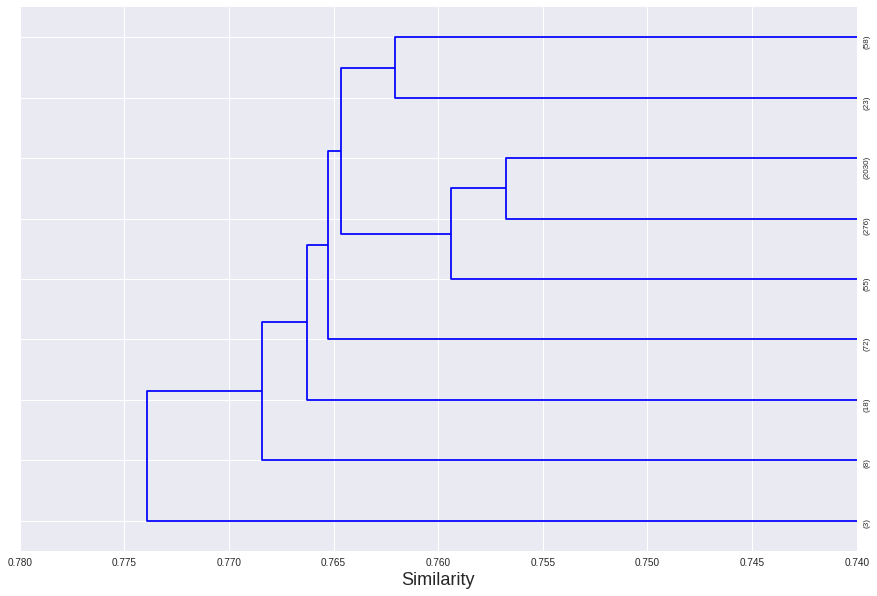

In [59]:
plt.figure(figsize=(15, 10))
plt.xlabel('Similarity', fontsize = 18)
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
    truncate_mode = 'lastp',
    p = 9,
    orientation = 'left'
)
plt.xlim(0.78,0.74)
plt.show()

In [0]:
labels2 = clustering.fit_predict(X_sub)

In [47]:
label = []
for i in range(6):
  res = []
  temp_label = np.where(labels2 == (i))
  temp_X = X_sub[temp_label]
  cen = centroid(temp_X)
  distance = cosine_similarity(temp_X, cen.reshape(1,-1))
  distance = np.absolute(distance)
  a = distance.reshape(1,-1).argsort()[0][-10:]
  print('cluster', i)
  for k in range(len(a)):
    res.append(find_key(temp_X[a[k]]))
  print(res)

cluster 0
['gig', 'thursday', 'week', 'saturday', 'evening', 'day', 'sweepstakes', 'night', 'afternoon', 'weekend']
cluster 1
['chin', 'breast', 'mouth', 'arm', 'tail', 'nose', 'lip', 'rib', 'turnoff', 'palate']
cluster 2
['filet', 'lasagna', 'pastrami', 'tempura', 'bbe', 'sizzle', 'mizu', 'yorkie', 'yuzu', 'theyre']
cluster 3
['labor', 'abuse', 'torture']
cluster 4
['mid', 'downtown', 'middle', 'upper', 'nearby', 'west', 'south', 'midtown', 'east', 'upstate']
cluster 5
['editorial', 'expert', 'fair', 'limited', 'co', 'cooperative', 'firm', 'company']


In [0]:
temp_label = np.where(labels2 == (1))
temp_X = X_sub[temp_label]
cen = centroid(temp_X)
distance = cosine_similarity(temp_X, cen.reshape(1,-1))
distance = np.absolute(distance)
a = distance.reshape(1,-1).argsort()[0][-10:]


In [60]:
np.sum(distance)

40.6817666210453

### when deciding the most appropriate number of clusters, applying the similar logic of the elbow graph, draw a graph shows the relationship between the overall within class similarities and the number of clusters

In [0]:
def mse_cal(k, data):
  mse = []
  for i in range(1,k):
    lab = AgglomerativeClustering(n_clusters= i , affinity='cosine',linkage='average').fit_predict(data)
    res = 0
    for j in range(i):
      temp_label = np.where(lab == (j))
      temp_X = data[temp_label]
      cen = centroid(temp_X)
      distance = cosine_similarity(temp_X, cen.reshape(1,-1))
      distance = np.absolute(distance)
      res += np.sum(distance)
    mse.append(res)
  return mse

In [0]:
mse = mse_cal(50,X_sub)

Text(0,0.5,'the Overall Similarity')

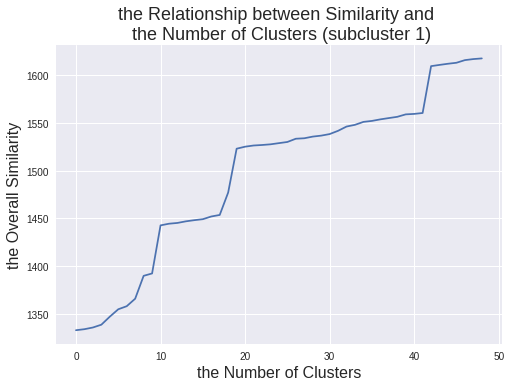

In [66]:
plt.plot(mse)
plt.title('the Relationship between Similarity and \n the Number of Clusters (subcluster 1)', fontsize = 18)
plt.xlabel('the Number of Clusters', fontsize = 16)
plt.ylabel('the Overall Similarity', fontsize = 16)

### comparing with the elbow graph, which depends on euclidean distance.

In [0]:
from sklearn.cluster import KMeans

In [0]:
mse_k = []
for i in range(1, 50):
  kmeans = KMeans(n_clusters = i, init = 'k-means++')
  kmeans.fit(X_sub)
  mse_k.append(kmeans.inertia_)

Text(0.5,1,'Elbow Graph')

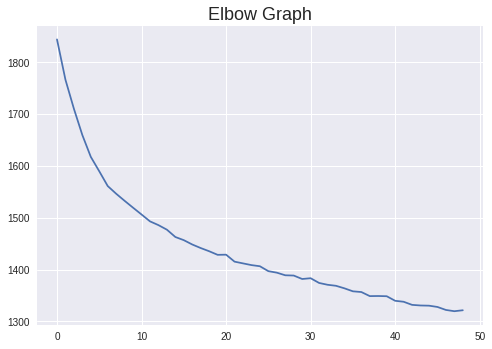

In [69]:
plt.plot(mse_k)
plt.title('Elbow Graph',fontsize = 18)

### comparing the clutser results from hierarchy based clustering mthods and distance based clustering methods

In [0]:
from sklearn.metrics.pairwise import pairwise_distances

In [0]:
def pre(data, cluster):
  lab = AgglomerativeClustering(n_clusters= cluster , affinity='cosine',linkage='average').fit_predict(data)
  print('Agglomerative Clustering and cosine similarity: ')
  print('The number of Clusters is :',len(np.unique(lab)),'\n')  
  for i in range(len(np.unique(lab))):
    res = []
    temp_label = np.where(lab == (i))
    temp_X = data[temp_label]
    cen = centroid(temp_X)
    distance = cosine_similarity(temp_X, cen.reshape(1,-1))
    distance = np.absolute(distance)
    a = distance.reshape(1,-1).argsort()[0][-25:]
    print('cluster', i)
    for k in range(len(a)):
      res.append(find_key(temp_X[a[k]]))
    print(res)
    
  print('\n')
  lab = KMeans(n_clusters = i, init = 'k-means++').fit_predict(data)
  print('K-means and Euclidean Distance: ')
  print('The number of Clusters is :',len(np.unique(lab)),'\n')
  for i in range(len(np.unique(lab))):
    res = []
    temp_label = np.where(lab == (i))
    temp_X = data[temp_label]
    cen = centroid(temp_X)
    distance = pairwise_distances(temp_X, cen.reshape(1,-1), metric='euclidean')
    distance = np.absolute(distance)
    a = distance.reshape(1,-1).argsort()[0][-25:]
    print('cluster', i)
    for k in range(len(a)):
      res.append(find_key(temp_X[a[k]]))
    print(res)

In [72]:
pre(X_sub,10)

Agglomerative Clustering and cosine similarity: 
The number of Clusters is : 10 

cluster 0
['soupy', 'appetizing', 'soggy', 'pepperoni', 'laidback', 'guacamole', 'nobu', 'kiku', 'touristy', 'artsy', 'nyi', 'pricey', 'balsamic', 'tipsy', 'filet', 'frizzy', 'lasagna', 'pastrami', 'bbe', 'tempura', 'sizzle', 'yorkie', 'mizu', 'yuzu', 'theyre']
cluster 1
['hip', 'teeth', 'corner', 'belly', 'flank', 'tongue', 'foot', 'edge', 'slope', 'ear', 'leg', 'thumb', 'tip', 'skin', 'stomach', 'chin', 'breast', 'mouth', 'arm', 'tail', 'nose', 'lip', 'rib', 'turnoff', 'palate']
cluster 2
['meal', 'gig', 'banquet', 'birthday', 'sunset', 'month', 'summer', 'lunch', 'hour', 'noon', 'dinner', 'vacation', 'holiday', 'weekday', 'morning', 'week', 'sunday', 'friday', 'thursday', 'saturday', 'day', 'night', 'evening', 'afternoon', 'weekend']
cluster 3
['occassions', 'vibe', 'tranquility', 'value', 'amount', 'description', 'item', 'acknowledgement', 'acidity', 'expectation', 'professionalism', 'quantity', 'conc

### expand the clusters
### read the whole pretrained wording embeddings in to a dictionary and use the most representative words from each cluster of the previous results as the target words to expand the clustering.
- take the cluster 2: ['filet', 'lasagna', 'pastrami', 'tempura', 'bbe', 'sizzle', 'mizu', 'yorkie', 'yuzu', 'theyre'] for example
- use each target word to expend the cluster for future tasks. Expand the cluster size to 25. The large scale could depend on the future applcation and requirement.

In [0]:
with bzopen("deps.words.bz2", "r") as bzfin:
    """ Handle lines here """
    dic = {}
    for i, line in enumerate(bzfin):
      a = line.rstrip()
      a = a.decode("utf-8")
      a = a.split(' ')
      dic[a[0]] = list(map(float,a[1:]))

In [0]:
target = ['filet', 'lasagna', 'pastrami', 'tempura', 'bbe', 'sizzle', 'mizu', 'yorkie', 'yuzu', 'theyre']

In [0]:
all_embed = [x for x in dic.values()]

In [75]:
all_embed = np.array(all_embed)
all_embed.shape

(174015, 300)

In [83]:
for word in target:
  res2 = []
  distance = cosine_similarity(np.array(dic[word]).reshape(1,-1), all_embed)
  distance = np.absolute(distance)
  dist = np.absolute(distance)
  a = dist.reshape(1,-1).argsort()[0][-25:]
 
  print('word', word)
  for k in range(len(a)):
    res2.append(find_key(all_embed[a[k]]))
  #print('center word is:', find_key(cluster0[i,]))
  print(res2)
  


word filet
['flan', 'heliotrope', 'croissant', 'hamsa', 'aubergine', 'bánh', 'dahi', 'roquefort', 'paan', 'ceviche', 'weenie', 'yorkie', 'spearmint', 'beefeater', 'fruitcake', 'shortbread', 'marmite', 'cutlet', 'shawarma', 'meatloaf', 'tempura', 'paneer', 'lasagna', 'wonton', 'filet']
word lasagna
['idli', 'matzah', 'shallot', 'falafel', 'vegemite', 'paneer', 'aubergine', 'pastrami', 'hummus', 'pepperoni', 'barbacoa', 'chorizo', 'shortbread', 'fufu', 'nutella', 'meatloaf', 'cornbread', 'gelato', 'coleslaw', 'wonton', 'ravioli', 'guacamole', 'tempura', 'tempeh', 'lasagna']
word pastrami
['laksa', 'risotto', 'lasagna', 'shortbread', 'yoghurt', 'kefir', 'crepes', 'soju', 'sashimi', 'fufu', 'nachos', 'paella', 'guacamole', 'shōchū', 'paneer', 'idli', 'sorbet', 'ravioli', 'nutella', 'coleslaw', 'tempura', 'meatloaf', 'tteok', 'tempeh', 'pastrami']
word tempura
['pulque', 'chorizo', 'shōchū', 'barbacoa', 'kefir', 'shallot', 'ceviche', 'falafel', 'guacamole', 'satay', 'sorbet', 'vegemite', 'i